#  Taxi Orders Prediction

The purpose of this study is to develop optimal model for predicting the number of taxi orders in next hour. There are historical data on taxi orders at airports provided. The target value of the RMSE metric must be not more than 48.

Here is a plan how we're going to act:
1. Load the data and resample it to one hour sections.
2. Data analysis.
3. Splitting the data into train and test sets. For test sample we'll take 10% of the original data.
4. Train different models with different hyperparameters.
5. Check the data on the test sample and draw conclusion.

## Data Loading and Preparation

In [1]:
# Importing required libraries
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor
from lightgbm import LGBMRegressor 

sns.set(rc={'figure.figsize':(14, 8)}, palette='Set2', font_scale=1.25)
warnings.filterwarnings('ignore')

In [2]:
# Fixating random state
RS = 23

### Data Loading

In [3]:
data = pd.read_csv('datasets/taxi.csv')

###  Data Exploration

In [4]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


There are only two columns with data. One with datetime and the other is contains number of orders. This is the number of orders for a period of 10 minutes.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


 There are 26496 rows in data. Datetime data should be converted to datetime type.

In [6]:
data.isna().sum()

datetime      0
num_orders    0
dtype: int64

No missed data found.

In [7]:
data['datetime'].min()

'2018-03-01 00:00:00'

In [8]:
data['datetime'].max()

'2018-08-31 23:50:00'

There are data from the 1st of March 2018 till 31st of August 2018. Only half a year.

Now let's look at the distribution of orders number.

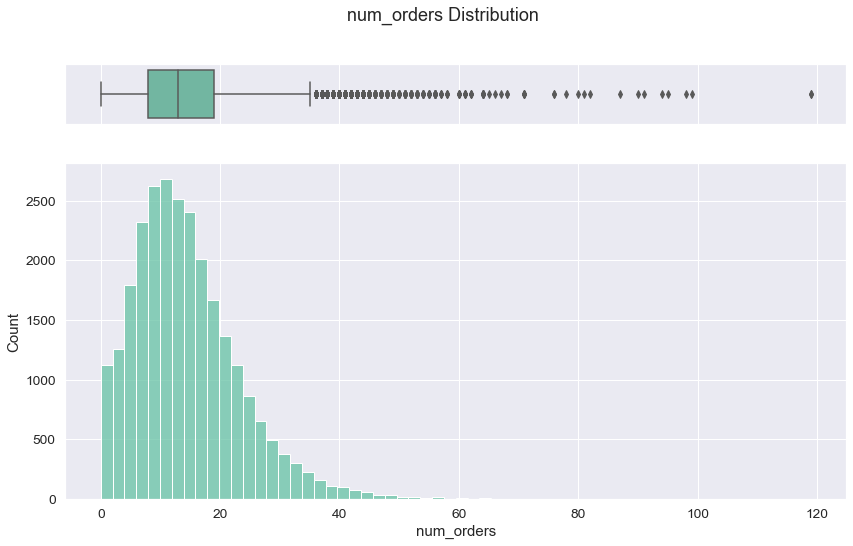

In [9]:
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(data['num_orders'], ax=ax_box)
sns.histplot(data=data, x='num_orders', ax=ax_hist, bins=60)
ax_box.set(xlabel='')

fig.suptitle('num_orders Distribution')
plt.show()

In [10]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


The distribution is slightly shifted to the left. The average value of the number of orders is 14 orders / 10 minutes. Median - 13.

### Converting Data to Timeseries

Cconverting the datetime type

In [11]:
data['datetime'] = pd.to_datetime(data['datetime'])

Now converting the dataset into a time series by replacing the index with values from the datetime column

In [12]:
data = data.set_index('datetime')

Checking for monotonic trend.

In [13]:
data.index.is_monotonic

True

Timeseries is monotonic.

Resampling to a one hour frequency.

In [14]:
data = data.resample('1H').sum()

### Summary

The original dataset had 26496 rows (data from March 1, 2018 to August 31, 2018). There are no missing values. The data type in the datetime column, object, has been changed to datetime64. Time intervals of 10 minutes. The dataset has been converted to a time series. Resampled to 1 hour frequency.

## Data Analysis

Let's plot the num_orders values column.

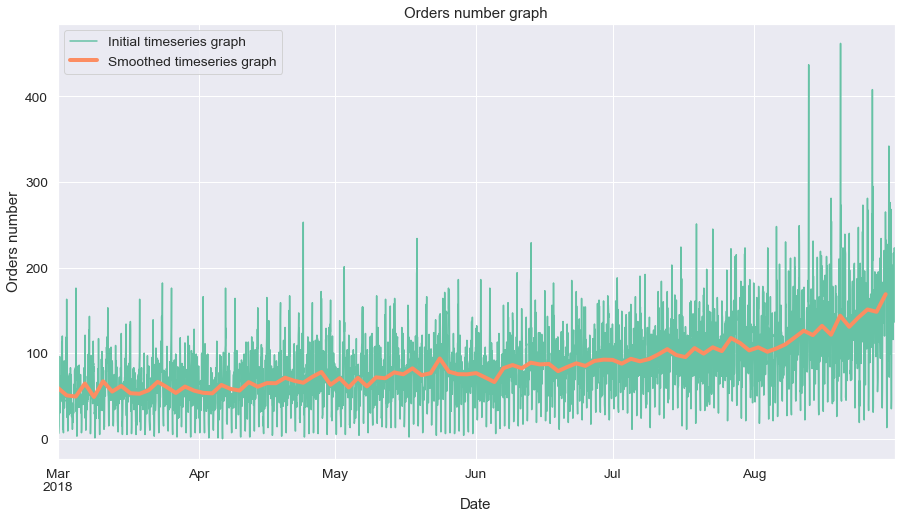

In [15]:
fig, ax = plt.subplots(figsize=(15, 8))
data.plot(ax=ax, title='Orders number')
data.resample('2D').mean().plot(ax=ax, title='Orders number graph', xlabel='Date', ylabel='Orders number', lw=4)
ax.legend(['Initial timeseries graph', 'Smoothed timeseries graph'])
plt.show();

Now decomposing and ploting the components of our data

#### Trend component

In [16]:
decomposition = seasonal_decompose(data)

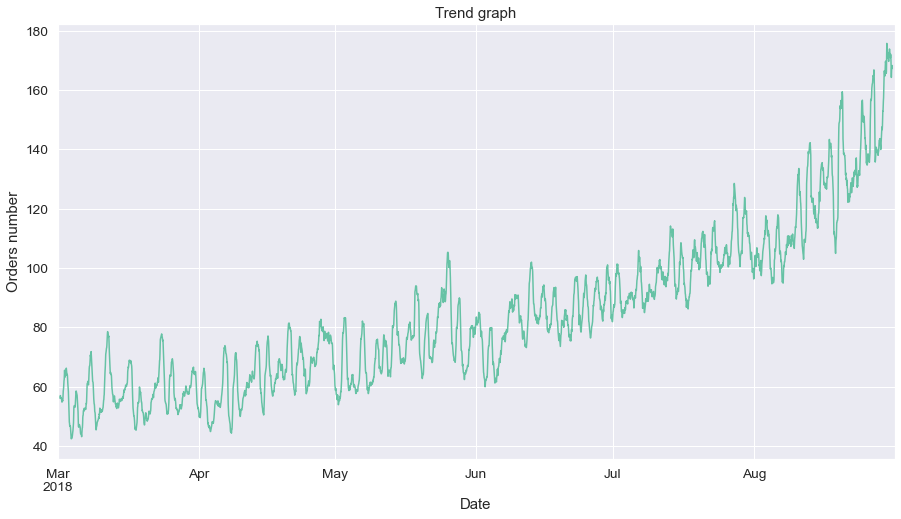

In [17]:
decomposition.trend.plot(figsize=(15, 8), title='Trend graph', xlabel='Date', ylabel='Orders number');

#### Seasonal Component

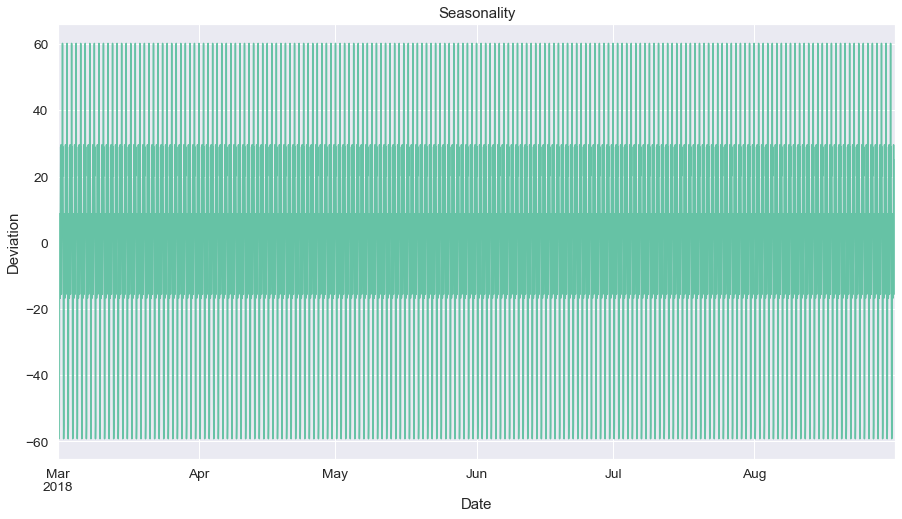

In [18]:
decomposition.seasonal.plot(figsize=(15, 8), title='Seasonality', xlabel='Date', ylabel='Deviation');

Let's look closer to a seasonal component.

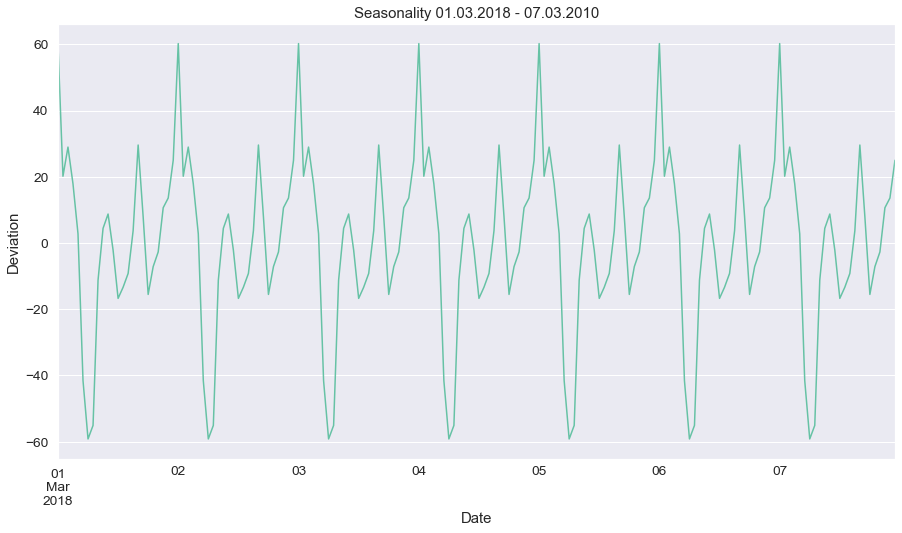

In [19]:
decomposition.seasonal.loc['2018-03-01': '2018-03-07'].plot(figsize=(15, 8), title='Seasonality 01.03.2018 - 07.03.2010', xlabel='Date', ylabel='Deviation');

There is a daily seasonality in data.

#### Residual component

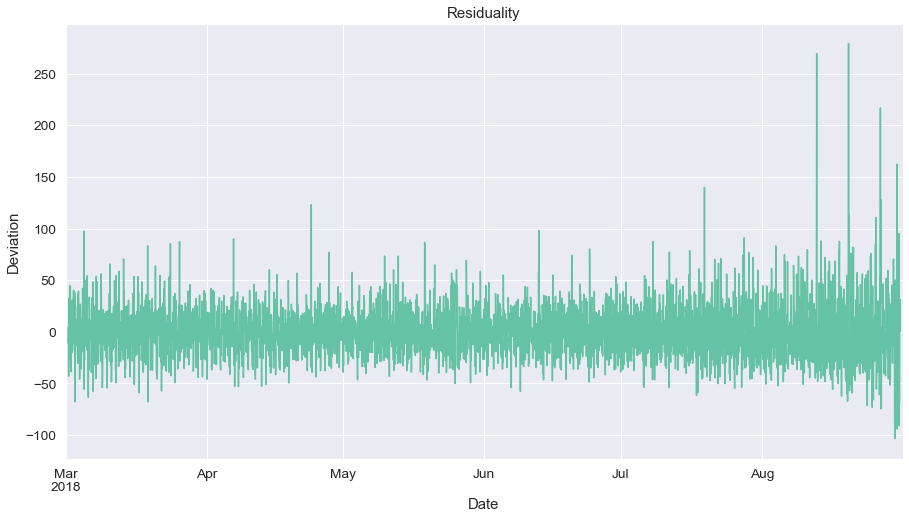

In [20]:
decomposition.resid.plot(figsize=(15, 8), title='Residuality', xlabel='Date', ylabel='Deviation');

Let's decompose the resampled time series by the day frequency components.

#### Trend component

In [21]:
decomposition_daily = seasonal_decompose(data.resample('1D').sum())

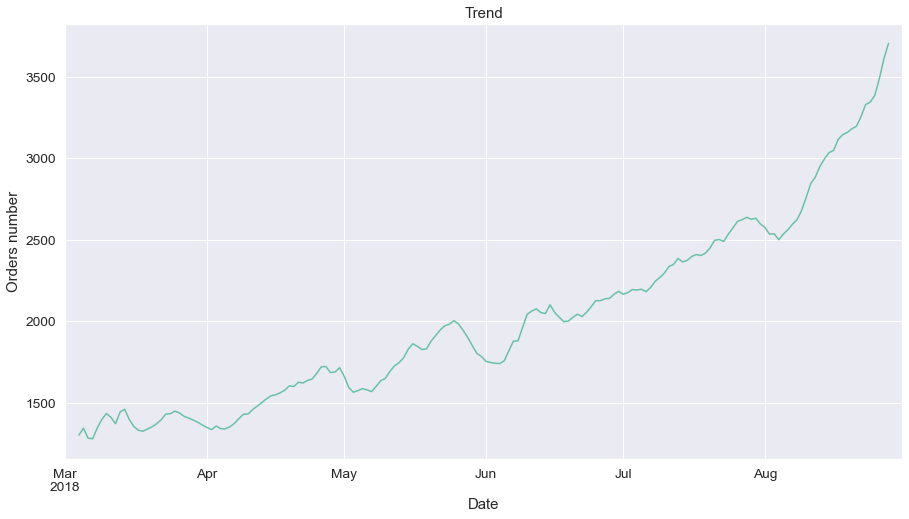

In [22]:
decomposition_daily.trend.plot(figsize=(15, 8), title='Trend', xlabel='Date', ylabel='Orders number');

#### Season component

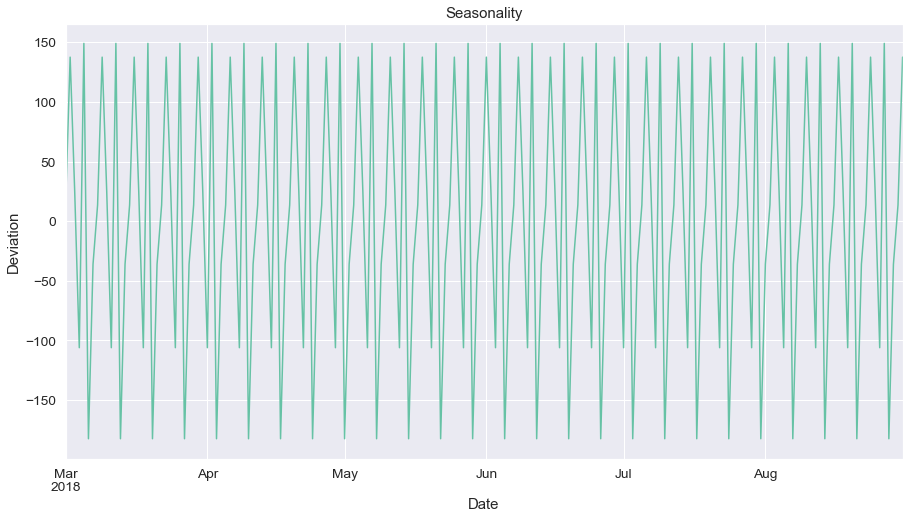

In [23]:
decomposition_daily.seasonal.plot(figsize=(15, 8), title='Seasonality', xlabel='Date', ylabel='Deviation');

On the chart of the seasonal component, there is a pattern that repeats about 4 times a month - weekly seasonality. Let's consider in more detail.

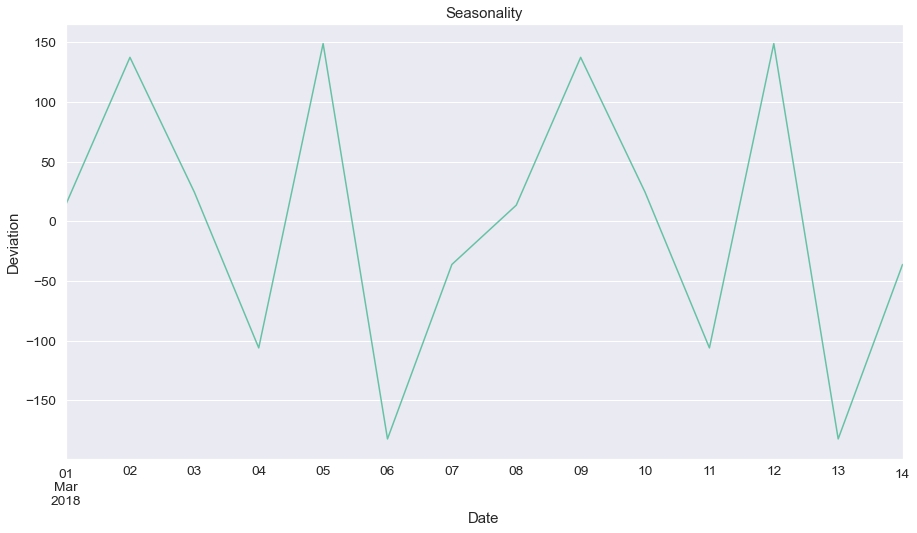

In [24]:
decomposition_daily.seasonal.iloc[0:14].plot(figsize=(15, 8), title='Seasonality', xlabel='Date', ylabel='Deviation');

On the weekly seasonality chart there are peaks on Fridays and Mondays and dips on Tuesdays and Sundays.

#### Residual Component

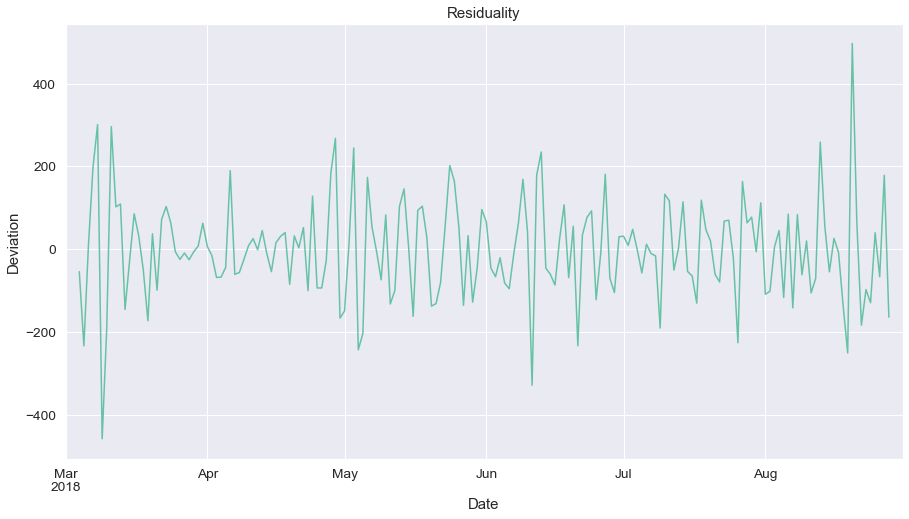

In [25]:
decomposition_daily.resid.plot(figsize=(15, 8), title='Residuality', xlabel='Date', ylabel='Deviation');

### Autocorrelation Functions

#### ACF (Autocorrelation Function)

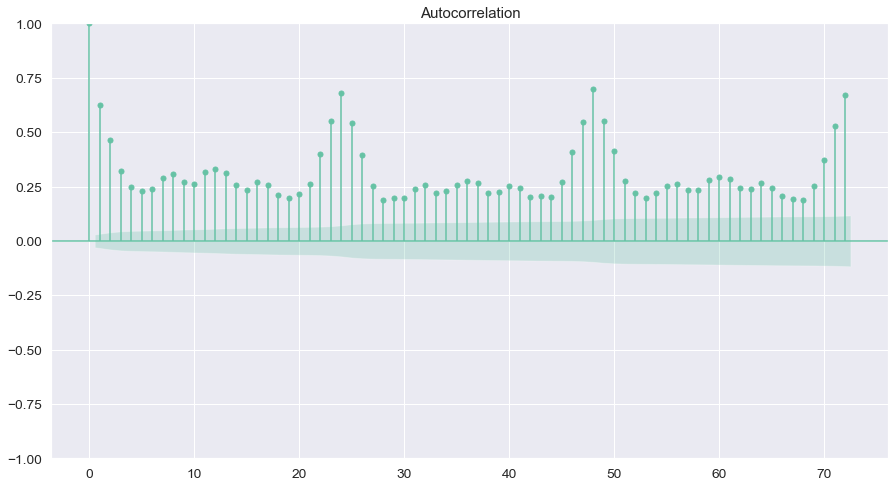

In [26]:
# Plotting ACF with 72 lags
plt.rc("figure", figsize=(15,8))
acf_plot = plot_acf(data['num_orders'], lags=72)

Here we can observe that data have a correlation with lags eqal 24, 48 hours and so on. There are also significant correlation between neigboring hours with lags 1 and 2 hours.

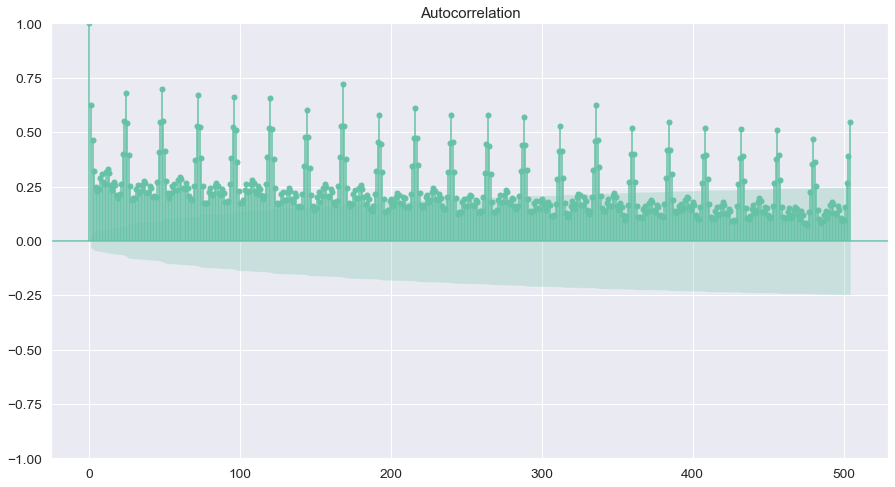

In [27]:
# Making a greater scale
acf_plot = plot_acf(data['num_orders'], lags=72*7)

Correlation in values with a weekly and two-weekly shift is also noticable(shift around 168 hours, etc.).

#### PACF (Partial Autocorrelation Function)

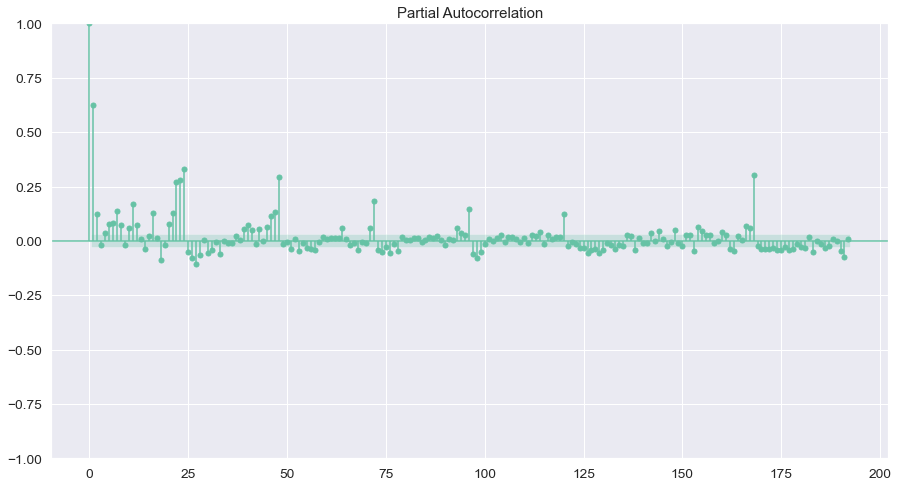

In [28]:
pacf_plot = plot_pacf(data['num_orders'], lags=24*8)

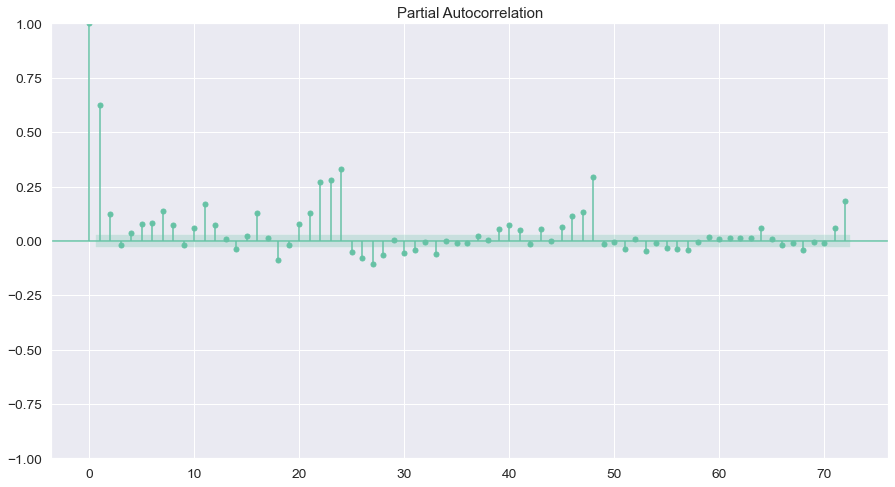

In [29]:
pacf_plot = plot_pacf(data['num_orders'], lags=72)

The plot of the partial correlation function confirms the observations made above.

### Summary

During the analysis of the available data, daily and weekly seasonality was found.

From the total and partial autocorrelation plots, we found strong autocorrelation across the data with the following shifts:
- 1 hour
- 2 hours
- 23 hours
- 24 hours (day)
- 48 hours (two days)
- 168 hours (week)

## Data Preprocessing

### Feature Generation

Let's create the following features:
  - day of the week
  - hour of the day in 24 hour format
  - the number of orders in the previous one hour and two hours
  - the number of orders at the same hour a day ago, as well as a day ago minus 1 hour
  - the number of orders at the same hour two days ago
  - number of orders at the same hour a week ago
  - 12-hour moving average of orders number

In [30]:
def feature_gen(data):
    """
    Feature Generation Function
    """
    data['weekday'] = data.index.day_of_week
    data['hour'] = data.index.hour
    for hour in [1, 2, 23, 24]:
        data['{}h_lag'.format(hour)] = data['num_orders'].shift(hour)
    data['week_lag'] = data['num_orders'].shift(24*7)
    data['rolling_mean_12h'] = data["num_orders"].rolling(window=12, closed='left').mean()
    return data.dropna()

In [31]:
data = feature_gen(data)

#### Features Correlation

Let's explore multicollinearity. The multicollinearity threshold is usually 0.6-0.8.

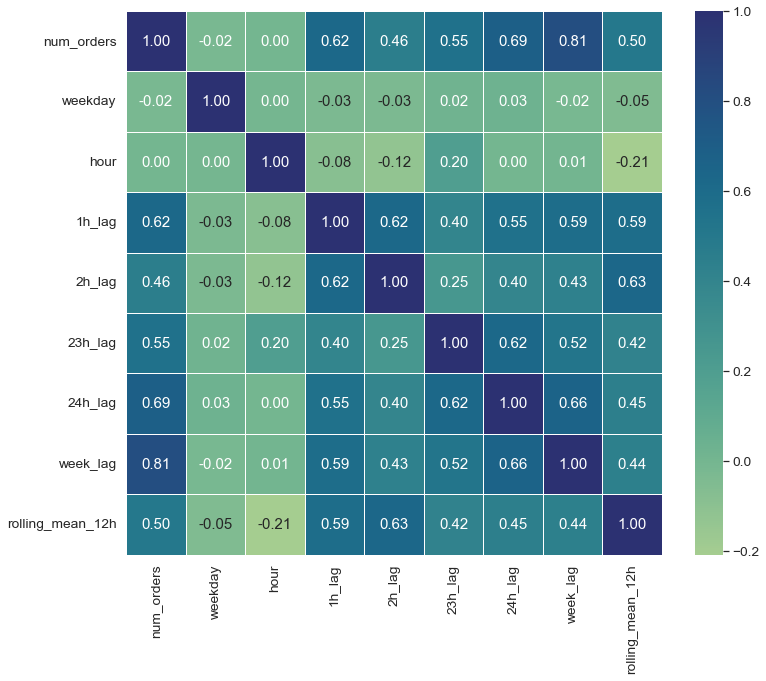

In [32]:
plt.subplots(figsize=(12,10))
sns.heatmap(data.corr(), annot=True, fmt='.2f', cmap="crest", linewidth=.5);

According to the correlation table, it can be assumed that the signs '1h_lag' and '2h_lag' have a little multicollinearity, as well as '23h_lag', '24h_lag', '48h_lag' and 'week_lag'.

###  Splitting into Train and Test Sets

Setting the shuffle to False to avoid the target leakage.

In [33]:
train, test = train_test_split(data, test_size=0.1, shuffle=False)

Checking the correctness of splitting

In [34]:
train.shape

(3823, 9)

In [35]:
test.shape

(425, 9)

In [36]:
train.index.max()

Timestamp('2018-08-14 06:00:00', freq='H')

In [37]:
test.index.min()

Timestamp('2018-08-14 07:00:00', freq='H')

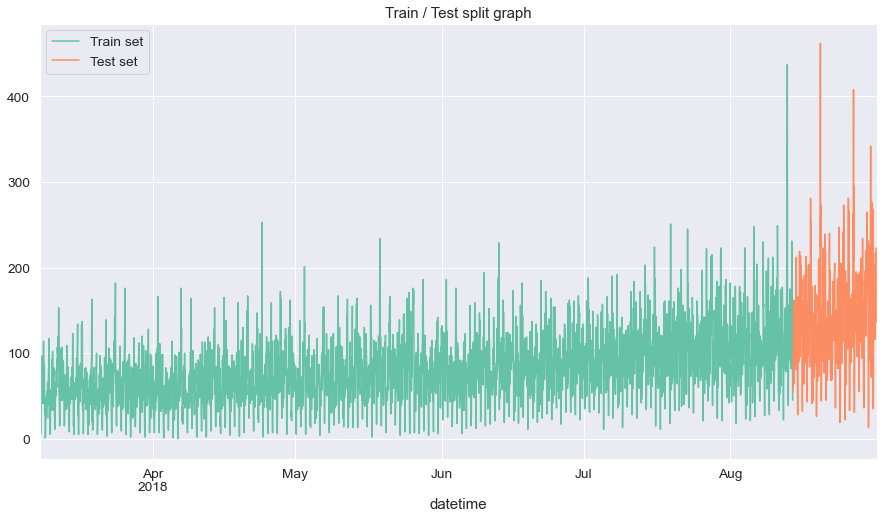

In [38]:
fig, ax = plt.subplots(figsize=(15, 8))
train['num_orders'].plot(ax=ax, label='Training set', title='Train / Test split graph')
test['num_orders'].plot(ax=ax, label='Test set')
ax.legend(['Train set', 'Test set'])
plt.show()

The splitting is done correctly.

Now extracting features and target.

In [39]:
X_train = train.drop('num_orders', axis=1)

In [40]:
y_train = train['num_orders']

In [41]:
X_test = test.drop('num_orders', axis=1)

In [42]:
y_test = test['num_orders']

## Models Train

Train set splitting for cross-validation

In [43]:
splits_number = 5
n_samples = X_train.shape[0]
block_size = n_samples // (splits_number + 1)

tss = TimeSeriesSplit(n_splits=splits_number, 
                      max_train_size=block_size, 
                      test_size=block_size)

Function for models training and hyperparameters tuning

In [44]:
def learning_cv(features, target, estimator, params, scaler=False):
    hrs = HalvingRandomSearchCV(estimator, 
                                param_distributions=params, 
                                cv=tss, 
                                scoring='neg_root_mean_squared_error', 
                                random_state=RS, 
                                n_candidates=50)
    hrs.fit(features, target)
    
    return hrs.best_estimator_, -hrs.best_score_, hrs.best_params_

### Linear Regression Model

Evaluation the value of the RMSE metric for the linear regression model

In [45]:
model_lr_scores = -cross_val_score(LinearRegression(), X_train, y_train, scoring='neg_root_mean_squared_error', cv=tss).mean()

In [46]:
model_lr_scores

23.26275792953913

In [47]:
model_lr = LinearRegression()

In [48]:
model_lr.fit(X_train, y_train)

LinearRegression()

### Extra Trees Model

In [49]:
params_et = {'n_estimators': range(50, 250, 50),
         'max_depth': range(1, 22, 2),
         'min_samples_split': range(2, 21, 2),
         'min_samples_leaf': range(1, 21, 2)}

In [50]:
et_model, et_scores, et_best_params = learning_cv(X_train, y_train, ExtraTreesRegressor(random_state=RS), params_et)

In [51]:
et_scores

28.026173627115405

In [52]:
et_best_params

{'n_estimators': 150,
 'min_samples_split': 12,
 'min_samples_leaf': 1,
 'max_depth': 9}

### Gradient Boosting Model LightGBM

In [53]:
params_lgb = {'n_estimators': range(50, 351, 50),
              'max_depth': range(1, 22, 2),
              'learning_rate': np.arange(0.01, 0.1, 0.01)}

In [54]:
lgb_model, lgb_scores, lgb_best_params = learning_cv(X_train, y_train, LGBMRegressor(random_state=RS), params_lgb)

In [55]:
lgb_scores

29.667402064225428

In [56]:
lgb_best_params

{'n_estimators': 250, 'max_depth': 3, 'learning_rate': 0.05}

### Summary

- The dataset was splitted into training and test sets, and features were also extracted.
- 3 ML models were trained - linear regression, extra trees forest and gradient boosting. The best value of the RMSE metric on cross-validation turned out to be in the linear regression model.

## Model Test

Checking for the adequacy in comparison with the forecast for the previous value.

In [57]:
pred_previous = y_test.shift(fill_value=y_train.iloc[-1])

In [58]:
mean_squared_error(y_test, pred_previous, squared=False)

58.819724582830204

The best model on test set.

In [59]:
pred = model_lr.predict(X_test)

In [60]:
mean_squared_error(y_test, pred, squared=False)

34.67157718056372

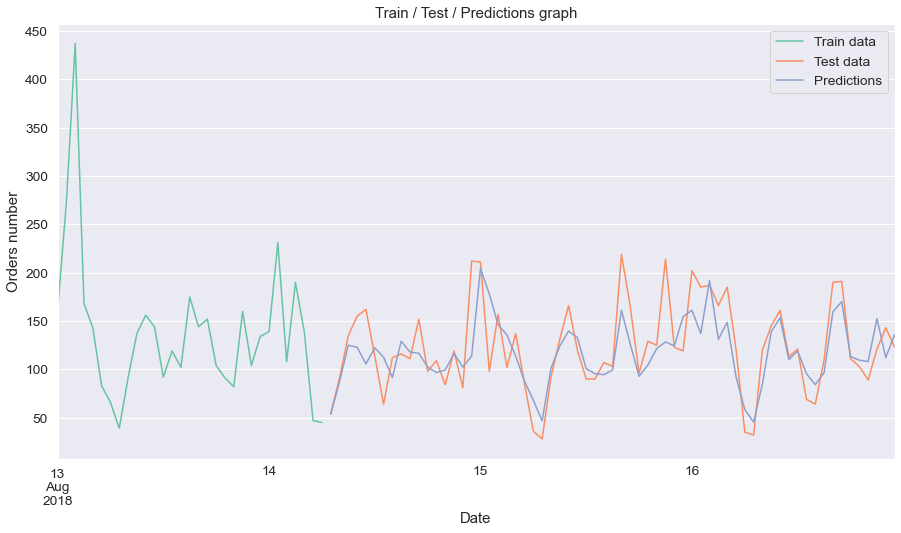

In [61]:
fig, ax=plt.subplots(figsize=(15, 8))
y_train.loc['2018-08-13': '2018-08-16'].plot(ax=ax, label='Train data')
y_test.loc['2018-08-13': '2018-08-16'].plot(ax=ax, label='Test data')
pd.DataFrame(pred, index=y_test.index, columns=['Predictions']).loc['2018-08-13': '2018-08-16'].plot(ax=ax, label='predictions')
ax.legend()
plt.title('Train / Test / Predictions graph')
plt.xlabel('Date')
plt.ylabel('Orders number');

In general, according to the graph, we can say that in most cases the predicted values are close to the real ones. Perhaps more factors should be taken into account - weather, holidays and vacations, etc.

### Conclusion

The model has an acceptable metrics value on the validation set - about 30% lower than the target one. The accuracy is higher than that of the previous value prediction model. Compared to the previous value prediction model, the linear regression model is about 100% better. According to the constructed comparative graph of the predicted and true values, it can be said that in most cases the predicted values are close to the real ones. Perhaps more factors should be taken into account - weather, holidays and vacations, etc.

## Summary

- The original dataset has 26496 rows (data from March 1, 2018 to August 31, 2018). There are no missing values. The data type in the datetime column, object, has been changed to datetime64. Time intervals of 10 minutes. The dataset has been converted to a time series. Resampled for 1 hour frequency.  
  
  
- During the analysis of the available data, daily and weekly seasonality was found. From the total and partial autocorrelation plots, we found strong autocorrelation across the data with the following shifts:  
  - 1 hour
  - 2 hours
  - 23 hours
  - 24 hours (day)
  - 48 hours (two days)
  - 168 hours (week)
  
  
- The following features have been created:  
    - day of the week
    - hour of the day in 24 hour format
    - the number of orders in the previous hour and two
    - the number of orders at the same hour a day ago, as well as a day minus 1 hour
    - number of orders at the same hour two days ago
    - number of orders at the same hour a week ago
    - 12-hour moving average of orders
    
    
- The dataset was splitted into training and test sets. Features and target were also extrated.
- Three machine learning models were trained - Linear Regression, Extra Trees Forest and Gradient Boosting. The best value of the RMSE metric on cross-validation turned out to be in the linear regression model.
  
  
- The model has an acceptable accuracy on the validation set - about 30% lower than the target. The accuracy is higher than based on the previous value prediction model. Compared to the previous value prediction model, the linear regression model is about 100% better. According to the constructed comparative graph of the predicted and true values, it can be said that in most cases the predicted values are close to the real ones. Perhaps more factors should be taken into account - weather, holidays and vacations, etc.